In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import librun
from librun import run, plot
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *

In [2]:
query_methods = {
    "random": partial(random_batch, n_instances=10),
    "uncertainty": partial(batch.uncertainty_batch_sampling, n_instances=10),
    **{
        name: partial(adversarial, Attack=attack, n_instances=10) for name, attack in 
        {
            "fgm": partial(FastGradientMethod, minimal=True),
            "deepfool": partial(DeepFool, verbose=False),
            "auto": AutoAttack,
            "boundary": partial(BoundaryAttack, verbose=False, targeted=False),
            "carliniL2": partial(CarliniL2Method, verbose=False),
            "carliniLinf": partial(CarliniLInfMethod, verbose=False),
            "hopskipjump": partial(HopSkipJump, verbose=False),
            #"auto pgd": partial(AutoProjectedGradientDescent, verbose=False),
            #"BrendelBethgeAttack": BrendelBethgeAttack,
            #"bim": BasicIterativeMethod,
            #"pgd": partial(ProjectedGradientDescentNumpy, verbose=False),
            #"newtonfool": partial(NewtonFool, verbose=False),
            #"saliency": partial(SaliencyMapMethod, verbose=False),
        }.items()
    }
}

In [69]:
datasets = {
    "car": car
}

In [70]:
results = {name: dict() for name in datasets.keys()}

KeyboardInterrupt: 

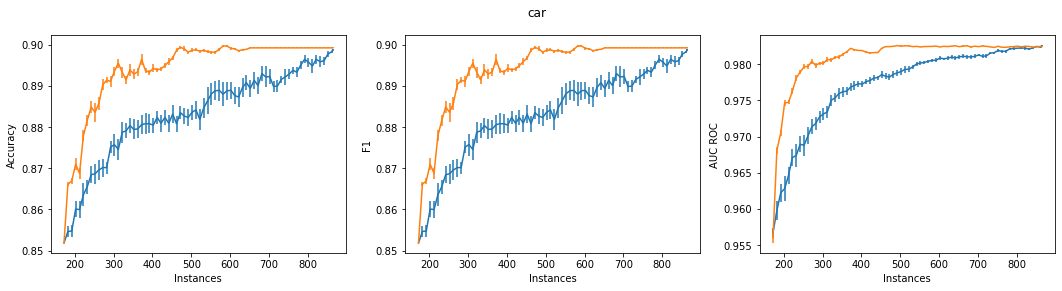

In [71]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(*dataset(), labeled_size=0.1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for method_name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10 if method_name == "random" or method_name == "uncertainty" else 4, desc=f"Run", leave=False)(
            delayed(
                lambda X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score]).active_learn2(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
            )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method))
            for _ in range(10 if method_name == "random" or method_name == "uncertainty" else 4)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        results[dataset_name][method_name] = (metrics, stderr)
        #metrics.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}.csv")
        #stderr.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{method_name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(dataset_name)
                
    fig.legend()
    fig.show();

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("haberman", lambda: lru_cache(haberman)()),
        ("banknote", lambda: lru_cache(banknote)()),
        #("car", lambda: lru_cache(car)())
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ('fgm', partial(adversarial, Attack=partial(FastGradientMethod, minimal=True), n_instances=10, teach_adversarial=False)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False))),
        ("auto", partial(adversarial, Attack=AutoAttack)),
        ("boundary", partial(adversarial, Attack=partial(BoundaryAttack, verbose=False, targeted=False))),
        ("carliniL2", partial(adversarial, Attack=partial(CarliniL2Method, verbose=False))),
        ("carliniLinf", partial(adversarial, Attack=partial(CarliniLInfMethod, verbose=False))),
        ("hopskipjump", partial(adversarial, Attack=partial(HopSkipJump, verbose=False))),
        ("auto pgd", partial(adversarial, Attack=partial(AutoProjectedGradientDescent, verbose=False))),
        ("BrendelBethgeAttack", partial(adversarial, Attack=BrendelBethgeAttack)),
        ("bim", partial(adversarial, Attack=BasicIterativeMethod)),
        ("pgd", partial(adversarial, Attack=partial(ProjectedGradientDescentNumpy, verbose=False))),
        ("newtonfool", partial(adversarial, Attack=partial(NewtonFool, verbose=False))),
        ("saliency", partial(adversarial, Attack=partial(SaliencyMapMethod, verbose=False))),
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1
    }
}

In [3]:
run(matrix)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.
